# Toy examples 2.0

Here I want to show how propensity score works using toy examples, so that this theory can be further developed on large models.

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import multivariate_normal, norm
from utils_update import compute_metrics
np.random.seed(48)

### Controlable generation data

Controlled generation of data and shift.

In [2]:
def generate_dataset(n_samples, n_features):
    X = np.random.randn(n_samples, n_features)
    noise = np.random.randn(n_samples)
    y = 2 * X[:, 0] + 3 * X[:, 1] + noise
    
    return X, y

def make_distribution_shift(X, y, shift_factor):
    X_shifted = X.copy()
    X_shifted[:, 0] *= shift_factor
    X_shifted[:, 1] /= shift_factor
    
    y_shifted = y * shift_factor
    
    return X_shifted, y_shifted

Let's look at one example of the generation result.

In [3]:
n_samples = 2000
n_features = 2
X_train, y_train = generate_dataset(n_samples, n_features)
X_shifted, y_shifted = make_distribution_shift(X_train, y_train, shift_factor=2)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
X_shifted_train, X_shifted_test, y_shifted_train, y_shifted_test = train_test_split(X_shifted, y_shifted, test_size=0.25, random_state=42)

In [4]:
regressor = LinearRegression().fit(X_train, y_train)

print(f"R2 score on original test data: {r2_score(y_test, regressor.predict(X_test))}")
print(f"MSE score on original test data: {mean_squared_error(y_test, regressor.predict(X_test))}")

R2 score on original test data: 0.9302389747029665
MSE score on original test data: 0.9910085342242777


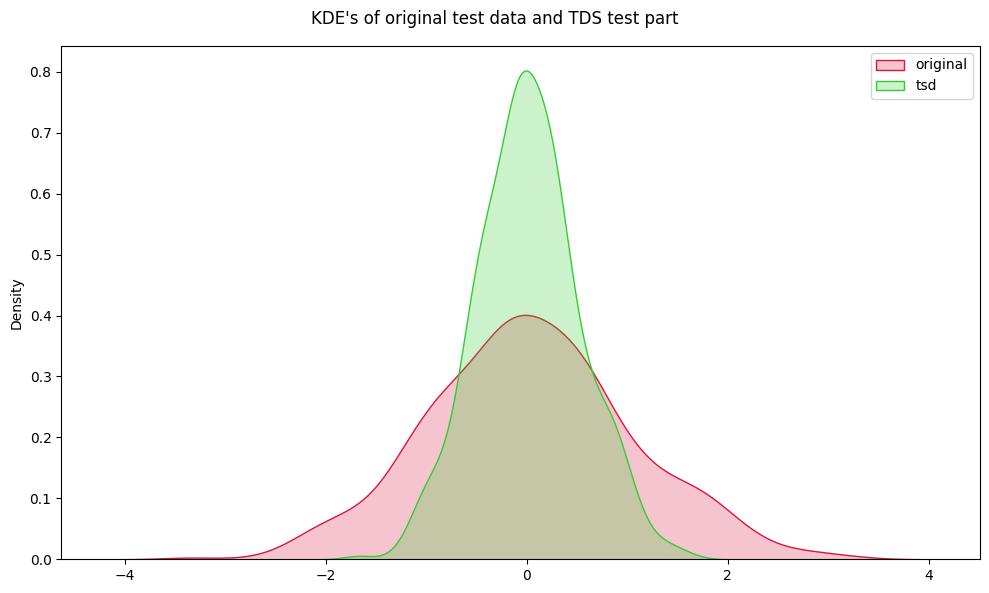

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("KDE's of original test data and TDS test part")
sns.kdeplot(data=X_test[:, 1],
            color='crimson', label='original', fill=True, ax=ax)
sns.kdeplot(data=X_shifted_test[:, 1],
            color='limegreen', label='tsd', fill=True, ax=ax)
ax.legend()
plt.tight_layout()
plt.show()

In [6]:
print(f"R2 score on TDS data w/o weights: {r2_score(y_shifted_test, regressor.predict(X_shifted_test))}")
print(f"MSE score on TDS data w/o weights: {mean_squared_error(y_shifted_test, regressor.predict(X_shifted_test))}")

R2 score on TDS data w/o weights: 0.5659823524106822
MSE score on TDS data w/o weights: 24.662205919914914


Now we need to train a classifier that can output for each data sample the probability of belonging to the new distribution. Today we will be using CalibratedClassifierCV and RandomForest.

In [25]:
sample_from_old = np.random.choice(len(X_train), size=250, replace=False)
sample_from_new = np.random.choice(len(X_shifted_train), size=250, replace=False) 

X_logreg = np.concatenate((X_train[sample_from_old], X_shifted_train[sample_from_new]), axis=0)
t = [1] * len(sample_from_old) + [0] * len(sample_from_new)

X_train_lg, _, y_train_lg, _ = train_test_split(X_logreg, t, test_size=0.0001, random_state=None, shuffle=True)
ccv = CalibratedClassifierCV(RandomForestClassifier(n_estimators=300, min_samples_leaf=40, max_depth=3), cv=3)

calibr = ccv.fit(X_train_lg, y_train_lg)

We can now get the predicted weights for the original test sample and the true weights using the pdf.

In [26]:
weights = [calibr.predict_proba(item.reshape(1, -1))[0][0] / (1 - calibr.predict_proba(item.reshape(1, -1))[0][0]) for item in X_test]

In [49]:
mvn_test = multivariate_normal(mean=np.mean(X_test, axis=0), cov=np.cov(X_test, rowvar=False))
mvn_shifted_test = multivariate_normal(mean=np.mean(X_shifted_test, axis=0), cov=np.cov(X_shifted_test, rowvar=False))

pdf_test = mvn_test.pdf(X_test)
pdf_shifted_test = mvn_shifted_test.pdf(X_test)

true_weights = pdf_shifted_test / pdf_test

Visualise distributions with predicted and true weights.

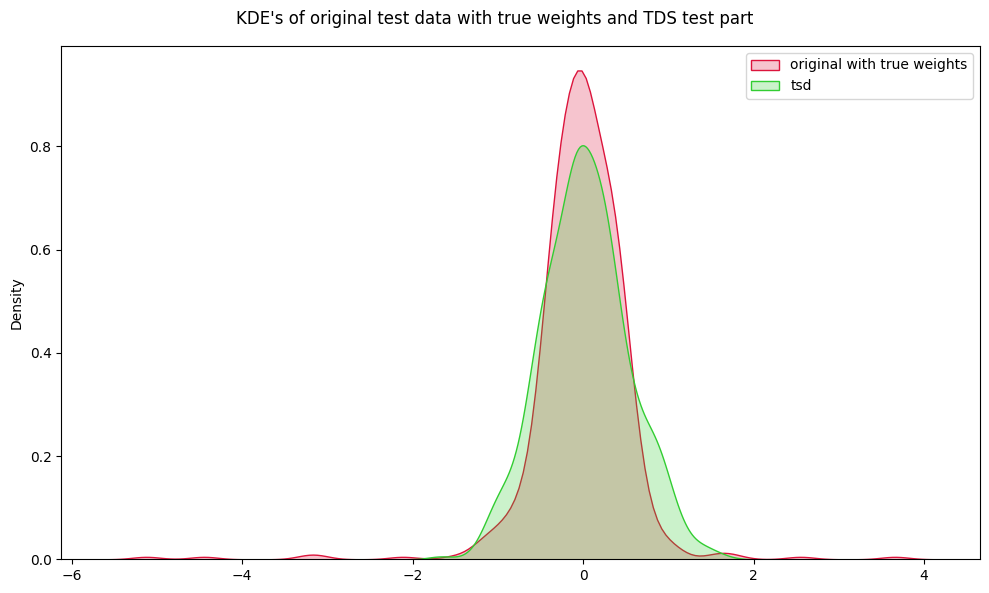

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("KDE's of original test data with true weights and TDS test part")
sns.kdeplot(data=true_weights * X_test[:, 1],
            color='crimson', label='original with true weights', fill=True, ax=ax)
sns.kdeplot(data=X_shifted_test[:, 1],
            color='limegreen', label='tsd', fill=True, ax=ax)
ax.legend()
plt.tight_layout()
plt.show()

equality of distibutions for each feature ≠ equality of multivariate distributions

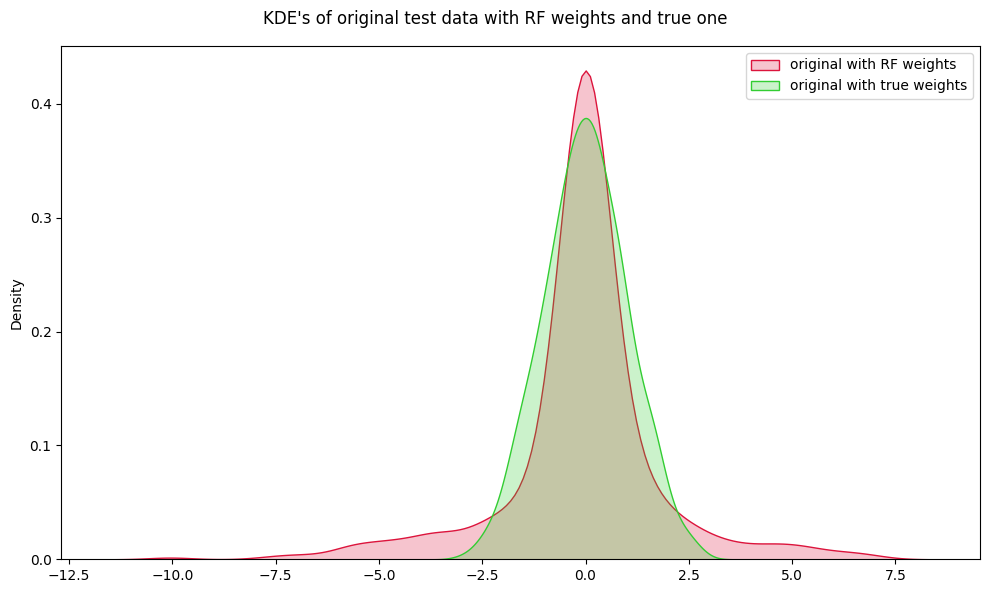

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("KDE's of original test data with RF weights and true one")
sns.kdeplot(data=weights * X_test[:, 0],
            color='crimson', label='original with RF weights', fill=True, ax=ax)
sns.kdeplot(data=true_weights * X_test[:, 0],
            color='limegreen', label='original with true weights', fill=True, ax=ax)
ax.legend()
plt.tight_layout()
plt.show()

In [30]:
print(f"R2 score on TDS data with weights: {r2_score(y_shifted_test, regressor.predict(X_shifted_test), sample_weight=weights)}")
print(f"MSE score on TDS data with weights: {mean_squared_error(y_shifted_test, regressor.predict(X_shifted_test), sample_weight=weights)}")

R2 score on TDS data with weights: 0.6728811341186796
MSE score on TDS data with weights: 16.975412129052124


### Confidence intervals across different shift values

In [18]:
n_samples = 2000
n_features = 2
X_train_true, y_train_true = generate_dataset(n_samples, n_features)
X_train, X_test, y_train, y_test = train_test_split(X_train_true, y_train_true, test_size=0.25, random_state=42)

ci_list = []
for item in tqdm([1, 1.5, 2.0, 2.5, 3, 5, 8, 10]):
    X_shifted, y_shifted = make_distribution_shift(X_train_true, X_train_true, shift_factor=2)

    X_shifted_train, X_shifted_test, y_shifted_train, y_shifted_test = train_test_split(X_shifted, y_shifted, test_size=0.25, random_state=42)
    
    ci = compute_metrics(X_train, y_train, X_test, X_shifted_train)
    ci_list.append(ci)

  0%|          | 0/8 [00:00<?, ?it/s]

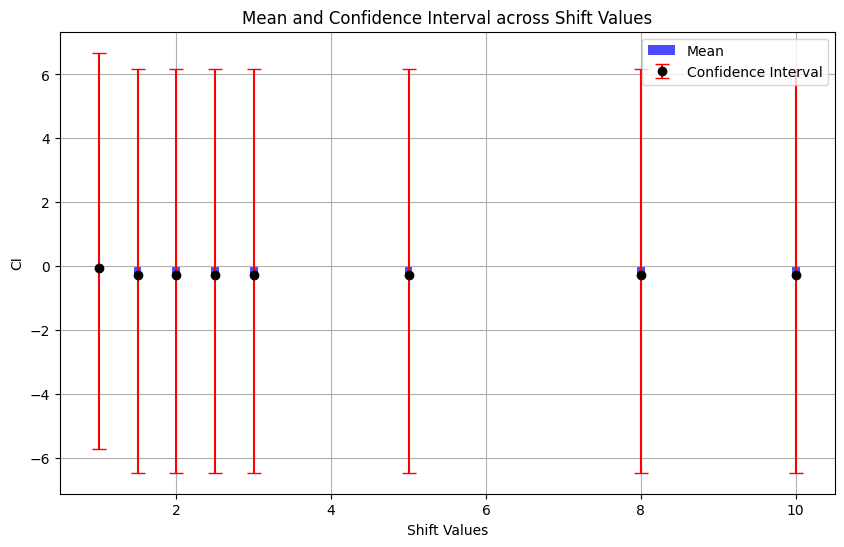

In [19]:
means = np.array([item[1][0] for item in ci_list])
shift_values = [1, 1.5, 2.0, 2.5, 3, 5, 8, 10]
lower_bounds = np.array([item[1][1][0] for item in ci_list])
upper_bounds = np.array([item[1][1][1] for item in ci_list])

plt.figure(figsize=(10, 6))
plt.bar(shift_values, means, width=0.1, color='blue', alpha=0.7, label='Mean')
plt.errorbar(shift_values, means, yerr=[means - lower_bounds, upper_bounds - means],
             fmt='o', color='black', ecolor='red', capsize=5, label='Confidence Interval')
plt.xlabel('Shift Values')
plt.ylabel('CI')
plt.title('Mean and Confidence Interval across Shift Values')
plt.legend()
plt.grid(True)
plt.show()

### HEP_ml approach

KS = Kolmogorov-Smirnov distance

In [21]:
from hep_ml.metrics_utils import ks_2samp_weighted

hist_settings = {'bins': 100, 'density': True, 'alpha': 0.7}
original_weights = np.ones(len(X_test))

def draw_distributions(original, target, new_original_weights):
    plt.figure(figsize=[15, 7])
    for id, column in enumerate([0, 1], 1):
        xlim = np.percentile(np.hstack([target[:, column]]), [0.01, 99.99])
        plt.subplot(2, 3, id)
        plt.hist(original[:, column], weights=new_original_weights, range=xlim, **hist_settings)
        plt.hist(target[:, column], range=xlim, **hist_settings)
        plt.title(column)
        print('KS over ', column, ' = ', ks_2samp_weighted(original[:, column], target[:, column], 
                                         weights1=new_original_weights, weights2=np.ones(len(target), dtype=float)))

KS over  0  =  0.1810000000000001
KS over  1  =  0.1770000000000001


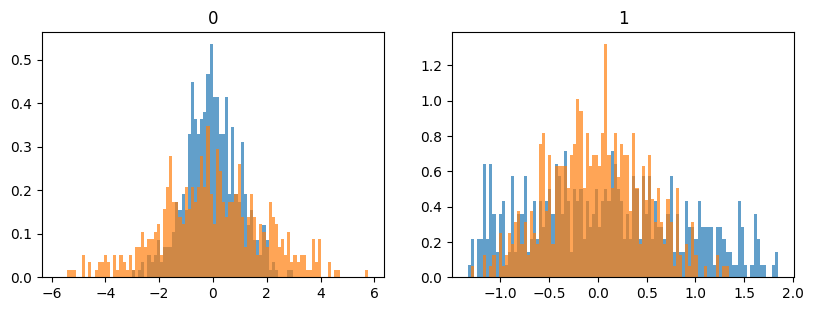

In [22]:
draw_distributions(X_test, X_shifted_test, original_weights)

KS over  0  =  0.11719918369832527
KS over  1  =  0.060437946774664075


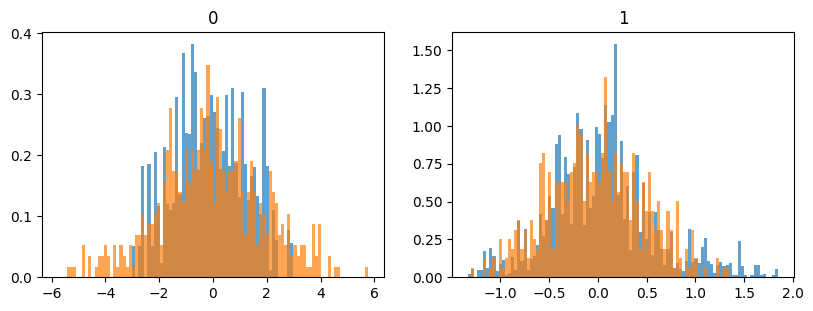

In [23]:
from hep_ml import reweight

bins_reweighter = reweight.BinsReweighter(n_bins=20, n_neighs=1.)
bins_reweighter.fit(X_train, X_shifted_train)

bins_weights_test = bins_reweighter.predict_weights(X_test)
draw_distributions(X_test, X_shifted_test, bins_weights_test)

KS over  0  =  0.08192879478367421
KS over  1  =  0.11473317997662968


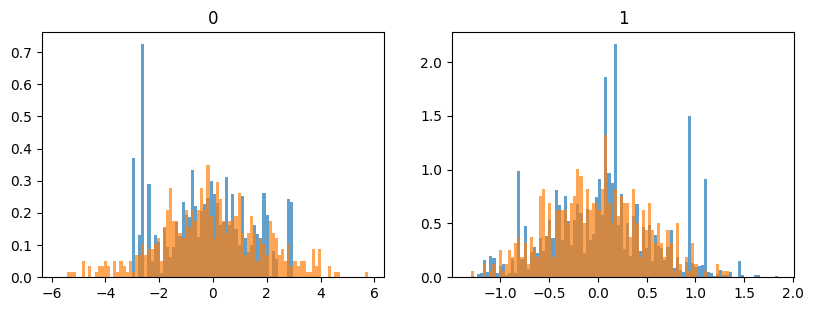

In [24]:
reweighter = reweight.GBReweighter(n_estimators=300, learning_rate=0.01, max_depth=5, min_samples_leaf=100, 
                                   gb_args={'subsample': 0.9})
reweighter.fit(X_train, X_shifted_train)

gb_weights_test = reweighter.predict_weights(X_test)
draw_distributions(X_test, X_shifted_test, gb_weights_test)

Let's check how well a classifier is able to distinguish these distributions. 
ROC AUC is taken as a measure of quality.

Before that I trained a classifier do distinguish these distributions. 
If ROC AUC = 0.5 on test, distibutions are identical, if ROC AUC = 1.0, they are ideally separable.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

data = np.concatenate([X_test, X_shifted_test])
labels = np.array([0] * len(X_test) + [1] * len(X_shifted_test))

weights = {}
weights['original'] = np.ones(len(X_test))
weights['bins'] = bins_weights_test
weights['gb_weights'] = gb_weights_test


for name, new_weights in weights.items():
    W = np.concatenate([new_weights / new_weights.sum() * len(X_shifted_test), [1] * len(X_shifted_test)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51)
    clf = GradientBoostingClassifier(subsample=0.3, n_estimators=50).fit(Xtr, Ytr, sample_weight=Wtr)
    
    print(name, roc_auc_score(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts))

original 0.7555778055903213
bins 0.5800727431522571
gb_weights 0.5848319114827069
